In [1]:
!date

Tue Feb  6 06:15:47 EST 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-COMORB-CVAE/Code'

In [3]:
%%time
print('importing')
import ants
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import shutil

importing


/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


CPU times: user 2.49 s, sys: 1.32 s, total: 3.81 s
Wall time: 7min 19s


In [4]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [5]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

In [6]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True,tmp_dir='/scratch/bergerar/'):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets',textfontcolor='black')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly',outprefix=tmp_dir) # learns a vector field from small to big sphere
    #print(mytx)
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='nearestNeighbor')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22,textfontcolor='black')
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map',textfontcolor='black')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    #J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    #J = J-1
    #J[abs(J.numpy())<.25]=0
    #if do_plot==True:
    #    warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

In [7]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# import os
# from matplotlib import pyplot as plt
# import umap
# from IPython import display
# import time
# import pandas as pd
# from sklearn.metrics import silhouette_score

# import seaborn as sns
#from sklearn.decomposition import PCA
#from umap import UMAP

    

def fit_rsa(rdm_data,rdm_model):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)
    
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec



In [40]:
def plot_brain(mat):
    #mat = mat-mat[0,0,0]
    #mat = (mat-mat.min()) / (mat.max()-mat.min())
    #mat = (mat-mat.mean()) / mat.std()
    #vmin = mat.min()*.25
    #vmax = mat.max()*.75
    mat = mat.astype(np.float32)
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    #print((mat.min(),mat.max()))
    #print(mat[0,0,0])
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1);plt.imshow(np.rot90(mat[:,:,32]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,2);plt.imshow(np.rot90(mat[:,32,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,3);plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)

In [9]:
brain_size = (64,64,64)

In [10]:
temp = ants.image_read('../Misc/Atlas_brain_2mm.nii',reorient=False)
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()
temp.to_filename('../Misc/Atlas_brain_2mm_64iso.nii')

In [11]:
tmp_dir = '/scratch/aglinska/' + 'ants_temp_'+str(np.random.randint(low=10000,high=110000))+'/'
safe_mkdir(tmp_dir)
print(tmp_dir)

/scratch/aglinska/ants_temp_55349/


In [16]:
td_locs = (32,32,32)
asd_locs = (14,34,20)
adhd_locs = (32,48,25)
comorb_locs = (32,22,37)

In [17]:
n_subs = 500

In [18]:
td_tx = []
adhd_tx = []
asd_tx = []
comorb_tx = []

for i in tqdm(range(n_subs)):
    td_sphere1 = np.random.uniform(low=10.0,high=35,size=1)
    td_sphere_diff = np.random.uniform(low=-5.0,high=5.0,size=1)
    td_sphere2 = td_sphere1+td_sphere_diff
    
    adhd_sphere1 = np.random.uniform(low=6.0,high=15,size=1)
    adhd_sphere_diff = np.random.uniform(low=1.0,high=5.0,size=1)    
    adhd_sphere2 = adhd_sphere1+adhd_sphere_diff
    
    asd_sphere1 = np.random.uniform(low=6.0,high=15,size=1)
    asd_sphere_diff = np.random.uniform(low=1.0,high=5.0,size=1)    
    asd_sphere2 = asd_sphere1+asd_sphere_diff
    
    comorb_sphere1 = np.random.uniform(low=6.0,high=15,size=1)
    comorb_sphere_diff = np.random.uniform(low=1.0,high=5.0,size=1)    
    comorb_sphere2 = comorb_sphere1+comorb_sphere_diff
    
    td_tx.append( (td_sphere1,td_sphere_diff,td_sphere2) )
    adhd_tx.append( (adhd_sphere1,adhd_sphere_diff,adhd_sphere2) )
    asd_tx.append( (asd_sphere1,asd_sphere_diff,asd_sphere2) )
    comorb_tx.append( (comorb_sphere1,comorb_sphere_diff,comorb_sphere2) )
    
    
    TD_brain = do_selective_tx(temp,coords = td_locs,sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir=tmp_dir)
    COMORB_brain = do_selective_tx(TD_brain,coords = comorb_locs,sz1=comorb_sphere1,sz2=comorb_sphere2,do_plot=False,tmp_dir=tmp_dir)
    ASD_brain = do_selective_tx(COMORB_brain,coords = asd_locs,sz1=asd_sphere1,sz2=asd_sphere2,do_plot=False,tmp_dir=tmp_dir)
    ADHD_brain = do_selective_tx(COMORB_brain,coords = adhd_locs,sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir=tmp_dir)
    ADHD_ASD_brain = do_selective_tx(ADHD_brain,coords = asd_locs,sz1=asd_sphere1,sz2=asd_sphere2,do_plot=False,tmp_dir=tmp_dir)
    
    TD_brain.to_filename(f'../Data/synth-data-01/sub-TD-{i:04d}.nii.gz')
    COMORB_brain.to_filename(f'../Data/synth-data-01/sub-COMORB-{i:04d}.nii.gz')
    ASD_brain.to_filename(f'../Data/synth-data-01/sub-ASD-{i:04d}.nii.gz')
    ADHD_brain.to_filename(f'../Data/synth-data-01/sub-ADHD-{i:04d}.nii.gz')
    ADHD_ASD_brain.to_filename(f'../Data/synth-data-01/sub-ADHD_ASD-{i:04d}.nii.gz')

np.save(f'../Data/synth-data-01/td_tx.npy',np.array(td_tx))
np.save(f'../Data/synth-data-01/adhd_tx.npy',np.array(adhd_tx))
np.save(f'../Data/synth-data-01/asd_tx.npy',np.array(asd_tx))
np.save(f'../Data/synth-data-01/comorb_tx.npy',np.array(comorb_tx))

100%|███████████████████████████████████████| 500/500 [1:34:44<00:00, 11.37s/it]


In [7]:
import os
import pandas as pd
import numpy as np
import ants
from tqdm import tqdm
from matplotlib import pyplot as plt

In [9]:
n_subs = 500

In [14]:
arr = np.zeros((n_subs,64,64,64))
for i in tqdm(range(n_subs)):
    arr[i,:,:,:] = ants.image_read(f'../Data/synth-data-01/sub-TD-{i:04d}.nii.gz').numpy()
np.save('../Data/synth-data-01-TD.npy',arr)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 90.97it/s]


In [17]:
arr = np.zeros((n_subs,64,64,64))
for i in tqdm(range(n_subs)):
    arr[i,:,:,:] = ants.image_read(f'../Data/synth-data-01/sub-COMORB-{i:04d}.nii.gz').numpy()
np.save('../Data/synth-data-01-COMORB.npy',arr)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 92.83it/s]


In [18]:
arr = np.zeros((n_subs,64,64,64))
for i in tqdm(range(n_subs)):
    arr[i,:,:,:] = ants.image_read(f'../Data/synth-data-01/sub-ASD-{i:04d}.nii.gz').numpy()
np.save('../Data/synth-data-01-ASD.npy',arr)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 93.97it/s]


In [19]:
arr = np.zeros((n_subs,64,64,64))
for i in tqdm(range(n_subs)):
    arr[i,:,:,:] = ants.image_read(f'../Data/synth-data-01/sub-ADHD-{i:04d}.nii.gz').numpy()
np.save('../Data/synth-data-01-ADHD.npy',arr)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 95.38it/s]


In [20]:
arr = np.zeros((n_subs,64,64,64))
for i in tqdm(range(n_subs)):
    arr[i,:,:,:] = ants.image_read(f'../Data/synth-data-01/sub-ADHD_ASD-{i:04d}.nii.gz').numpy()
np.save('../Data/synth-data-01-ADHD_ASD.npy',arr)

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 91.65it/s]


In [17]:
# np.save(f'../Data/synth-data-01/td_tx.npy',np.array(td_tx))
# np.save(f'../Data/synth-data-01/adhd_tx.npy',np.array(adhd_tx))
# np.save(f'../Data/synth-data-01/asd_tx.npy',np.array(asd_tx))
# np.save(f'../Data/synth-data-01/comorb_tx.npy',np.array(comorb_tx))

In [32]:
df = pd.DataFrame(np.load('../Data/synth-data-01/comorb_tx.npy')[:,:,0],columns=['sphere1','sphere_diff','sphere2']).to_csv('../Data/synth-data-01-comorb_tx.csv')

In [35]:
arr_td = np.load('../Data/synth-data-01-TD.npy')
arr_comorb = np.load('../Data/synth-data-01-COMORB.npy')
arr_asd = np.load('../Data/synth-data-01-ASD.npy')
arr_adhd = np.load('../Data/synth-data-01-ADHD.npy')
arr_asd_adhd = np.load('../Data/synth-data-01-ADHD_ASD.npy')

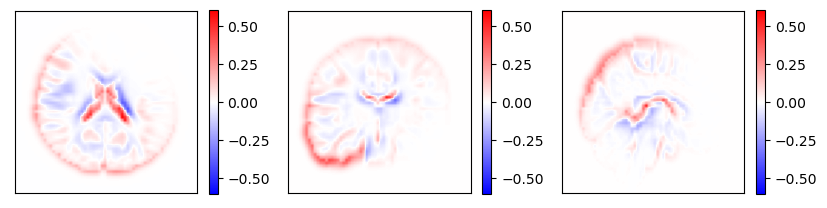

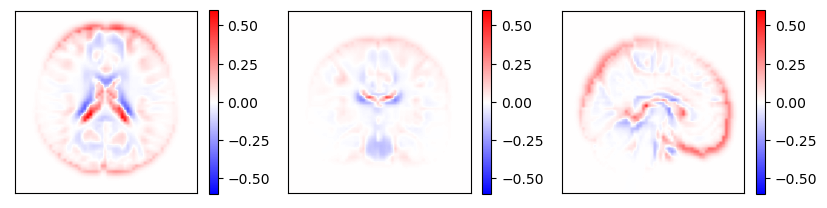

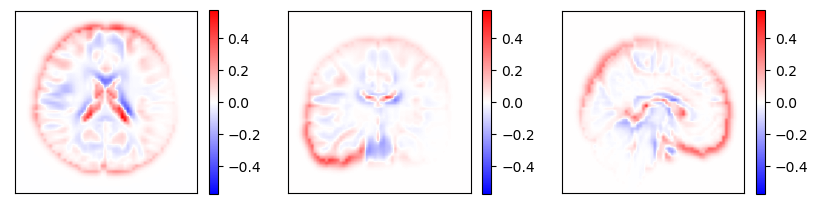

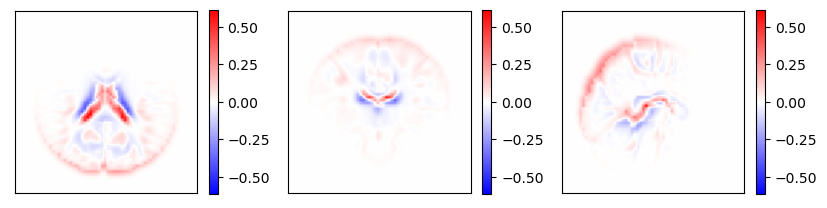

In [42]:
plot_brain((arr_asd-arr_td).mean(axis=0))
plot_brain((arr_adhd-arr_td).mean(axis=0))
plot_brain((arr_asd_adhd-arr_td).mean(axis=0))
plot_brain((arr_comorb-arr_td).mean(axis=0))